# NEO Detection Run

In [ ]:
# Standard libraries
import datetime
import math
import pathlib
import sqlite3
import sys

# Installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import spiceypy
import tqdm

# Append to root directory of this repository
sys.path.append("../")

# Auxiliary module that contains the apparent magnitude
from auxiliary import photometry

In [ ]:
# Accessing the NEO database
database_dir = pathlib.Path("../databases/neos/")
database_file = pathlib.Path("neodys.db")
database_filepath = database_dir / database_file

# Establish a connection to the database and set a cursor
neodys_db_con = sqlite3.connect(database_filepath)
neodys_db_cur = neodys_db_con.cursor()

# Get all information from the DB. Since the DB is rather small, this won't cause any issues!
neo_df = pd.read_sql("SELECT * FROM main", neodys_db_con)

# Close the database.
neodys_db_con.close()

In [ ]:
# Load SPICE kernels
spiceypy.furnsh("../kernels/spk/de432s.bsp")
spiceypy.furnsh("../kernels/lsk/naif0012.tls")
spiceypy.furnsh("../kernels/pck/gm_de431.tpc")

# Get the G*M value of the Sun
_, gm_sun_pre = spiceypy.bodvcd(bodyid=10, item='GM', maxn=1)
gm_sun = gm_sun_pre[0]

In [ ]:
# For our computations we need to convert some values from AU to km and from deg to rad
neo_df.loc[:, "Perihel_km"] = neo_df["Perihel_AU"].apply(lambda x: spiceypy.convrt(x, "AU", "km"))
neo_df.loc[:, "Incl_rad"] = neo_df["Incl_deg"].apply(lambda x: math.radians(x))
neo_df.loc[:, "LongAscNode_rad"] = neo_df["LongAscNode_deg"].apply(lambda x: math.radians(x))
neo_df.loc[:, "ArgP_rad"] = neo_df["ArgP_deg"].apply(lambda x: math.radians(x))
neo_df.loc[:, "MeanAnom_rad"] = neo_df["MeanAnom_deg"].apply(lambda x: math.radians(x))
neo_df.loc[:, "Epoch_JD"] = neo_df["Epoch_MJD"].apply(lambda x: x + 2400000.5)
neo_df.loc[:, "Epoch_et"] = neo_df["Epoch_JD"].apply(lambda x: spiceypy.utc2et(str(x) + " JD"))

In [ ]:
# Some simulation parameters (better way: creating a config file for maximum flexibility)
init_time_utc = "2010-01-01T00:00:00"
init_time_et = spiceypy.utc2et(init_time_utc)

# "Circle" around the opposition that is the detection area (in degrees)
opp_range = 15.0

# Minimum detection threshold (in magnitude)
mag_detec = 22.0

# Dataframe that stores the results
detected_neo_df = pd.DataFrame([])

# Simulation steps in hours
obs_steps = 24.0

# Observation range in hours
obs_range = 5.0 * 365.0 * 24.0 # 5 years

In [ ]:
# Simulation loop. For better effieciency this can be done asychronically
for time_step_h in tqdm.tqdm(np.arange(0, obs_range, 24.0)):

    # Computation time
    _time_et = init_time_et + (time_step_h * 3600.0)
    neo_df.loc[:, "et_of_detection"] = _time_et
    
    # Position vector of the Earth as seen from the Sun
    sun2earth_position_vec = spiceypy.spkgps(targ=399,
                                             et=_time_et,
                                             ref="ECLIPJ2000",
                                             obs=10)[0]
    earth2sun_position_vec = -1.0 * sun2earth_position_vec

    # Compute the position vector of each NEO as seen from the Sun
    neo_df.loc[:, "sun2neo_position_vec"] = \
        neo_df.apply(lambda x: spiceypy.conics(elts=[x["Perihel_km"],
                                                     x["Ecc_"],
                                                     x["Incl_rad"],
                                                     x["LongAscNode_rad"],
                                                     x["ArgP_rad"],
                                                     x["MeanAnom_rad"],
                                                     x["Epoch_et"],
                                                     gm_sun],
                                             et=_time_et)[:3],
                     axis=1)

    # To compute the apparent magnitude we need to re-compute the positional vectors and convert it
    # to AU
    neo_df.loc[:, "neo2earth_position_vec"] = \
        neo_df["sun2neo_position_vec"].apply(lambda x: sun2earth_position_vec - x)

    neo_df.loc[:, "neo2sun_position_vec"] = \
        neo_df["sun2neo_position_vec"].apply(lambda x: -1.0 * x)

    neo_df.loc[:, "neo2earth_position_vec_AU"] = \
        neo_df["neo2earth_position_vec"].apply(lambda x:
                                               [spiceypy.convrt(k, "km", "AU") for k in x])
    neo_df.loc[:, "neo2sun_position_vec_AU"] = \
        neo_df["neo2sun_position_vec"].apply(lambda x:
                                             [spiceypy.convrt(k, "km", "AU") for k in x])

    neo_df.loc[:, "earth2neo_position_vec_AU"] = \
        neo_df["neo2earth_position_vec_AU"].apply(lambda x: -1.0 * np.array(x))

    # Compute the apparent magnitude of each NEO
    neo_df.loc[:, "app_mag"] = \
        neo_df.apply(lambda x: photometry.hg_app_mag(abs_mag=x["AbsMag_"],
                                                     vec_obj2obs=x["neo2earth_position_vec_AU"],
                                                     vec_obj2ill=x["neo2sun_position_vec_AU"],
                                                     slope_g=x["SlopeParamG_"]), axis=1)

    # Compute the angular distance between NEO and opposition direction
    neo_df.loc[:, "ang_dist_neo2opp_deg"] = \
        neo_df["earth2neo_position_vec_AU"].apply(lambda x: np.degrees(spiceypy.vsep(x, -1.0*earth2sun_position_vec)))

    # Get the detected NEOs
    detec_rows = neo_df.loc[(neo_df["app_mag"] <= mag_detec) & (neo_df["ang_dist_neo2opp_deg"] <= opp_range), :]

    # ... add them to the detected dataframe, remove them from the simulation
    detected_neo_df = pd.concat([detected_neo_df, detec_rows], ignore_index=True)
    neo_df.drop(detec_rows.index, inplace=True)
    
    # Dataframe empty? Quit
    if len(neo_df) == 0:
        break

In [ ]:
# Convert the ET detection time to a human-readable format
detected_neo_df.loc[:, "utc_of_detection"] = \
    detected_neo_df["et_of_detection"].apply(lambda x: spiceypy.et2utc(x, "ISOC", 0))

In [ ]:
detected_neo_df = detected_neo_df[['Name',
                                   'SemMajAxis_AU',
                                   'Ecc_',
                                   'Incl_deg',
                                   'LongAscNode_deg',
                                   'ArgP_deg',
                                   'AbsMag_',
                                   'SlopeParamG_',
                                   'Aphel_AU',
                                   'Perihel_AU',
                                   'NEOClass',
                                   'utc_of_detection']].copy()

# Store the results in a parquet file
pathlib.Path("results_data/simulation").mkdir(parents=True, exist_ok=True)
detected_neo_df.to_parquet(f"results_data/simulation/" \
                           + f"UTC{init_time_utc}" \
                           + f"_OppDist{opp_range}" \
                           + f"_MagDetec{mag_detec}" \
                           + f"_StepSize{obs_steps}" \
                           + f"_HourObs{obs_range}.parquet")

In [ ]:
# We also store the undetected NEOs (for the sake of completion)
undetected_neo_df = neo_df[['Name',
                                   'SemMajAxis_AU',
                                   'Ecc_',
                                   'Incl_deg',
                                   'LongAscNode_deg',
                                   'ArgP_deg',
                                   'AbsMag_',
                                   'SlopeParamG_',
                                   'Aphel_AU',
                                   'Perihel_AU',
                                   'NEOClass']].copy()

undetected_neo_df.to_parquet(f"results_data/simulation/" \
                             + f"UNDETECTED_UTC{init_time_utc}" \
                             + f"_OppDist{opp_range}" \
                             + f"_MagDetec{mag_detec}" \
                             + f"_StepSize{obs_steps}" \
                             + f"_HourObs{obs_range}.parquet")

# NEO Detection Analysis

In [1]:
# Standard libraries
import datetime
import math
import pathlib
import sqlite3
import sys

# Installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import spiceypy
import tqdm

# Append to root directory of this repository
sys.path.append("../")

# Auxiliary module that contains the apparent magnitude
from auxiliary import photometry

In [2]:
# Load the simulation results
detected_neo_df = pd.read_parquet("results_data/simulation/UTC2010-01-01T00_00_00_OppDist15.0_MagDetec22.0_StepSize24.0_HourObs43800.0.parquet")
undetected_neo_df = pd.read_parquet("results_data/simulation/UNDETECTED_UTC2010-01-01T00_00_00_OppDist15.0_MagDetec22.0_StepSize24.0_HourObs43800.0.parquet")

In [3]:
# Convert the detection time strings to a datetime object
detected_neo_df.loc[:, "utc_of_detection"] = detected_neo_df["utc_of_detection"].str[:10]
detected_neo_df.loc[:, "utc_of_detection"] = \
    detected_neo_df["utc_of_detection"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))

# Compute the detection day (w.r.t. the initial observation datetime)
detected_neo_df.loc[:, "delta_day_wrt_init"] = \
    detected_neo_df["utc_of_detection"].apply(lambda x: (x - detected_neo_df["utc_of_detection"].iloc[0]).days)

In [4]:
# Let's set a dark background
plt.style.use('dark_background')

# Set a default font size for better readability
plt.rcParams.update({'font.size': 14})

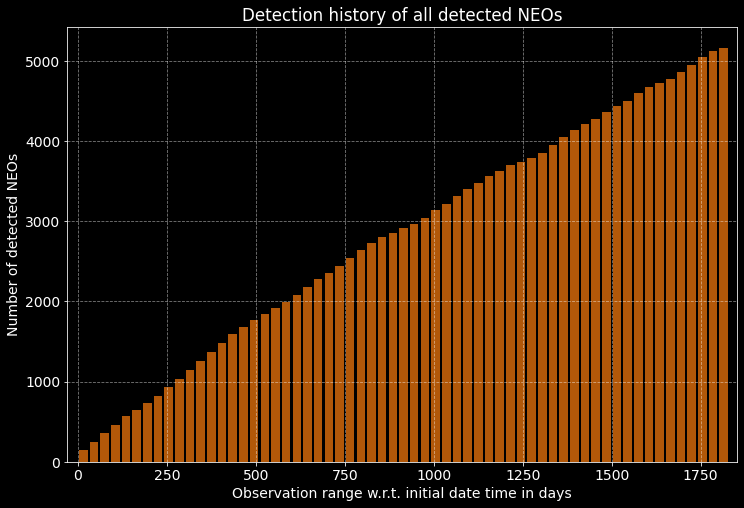

In [5]:
# A cumulative plot that shows how many NEOs we have been detected in our opposition area over
# time
fig, ax = plt.subplots(figsize=(12, 8))

# Cumulative histogram in 30 days bins
ax.hist(detected_neo_df["delta_day_wrt_init"],
        bins=np.arange(0, np.max(detected_neo_df["delta_day_wrt_init"]) + 30, 30),
        cumulative=True,
        color="tab:orange",
        alpha=.7,
        rwidth=0.8)

# Formating and layout
ax.set_xlim(-30, np.max(detected_neo_df["delta_day_wrt_init"]) + 30)

ax.set_title("Detection history of all detected NEOs")
ax.set_xlabel("Observation range w.r.t. initial date time in days")
ax.set_ylabel("Number of detected NEOs")

ax.grid(linestyle="--", alpha=0.5)

plt.show()

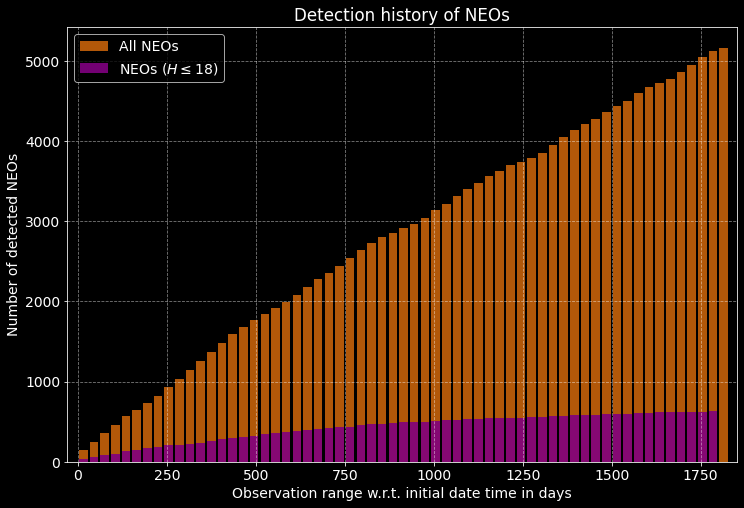

In [6]:
# Let's take a differentiated look at the size distribution of detected NEOs

# A second, overlapping histogram that show the larger NEOs (upper absolute magnitude limit of
# e.g., 18
absmag_limit = 18
temp_detected_neo_df = detected_neo_df.loc[detected_neo_df["AbsMag_"] <= absmag_limit].copy()

fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(detected_neo_df["delta_day_wrt_init"],
        bins=np.arange(0, np.max(detected_neo_df["delta_day_wrt_init"]) + 30, 30),
        cumulative=True,
        color="tab:orange",
        alpha=.7,
        rwidth=0.8,
        label="All NEOs")

ax.hist(temp_detected_neo_df["delta_day_wrt_init"],
        bins=np.arange(0, np.max(temp_detected_neo_df["delta_day_wrt_init"]) + 30, 30),
        cumulative=True,
        color="purple",
        alpha=.9,
        rwidth=0.8,
        label=fr"NEOs $(H\leq{absmag_limit})$")

# Layout and formatting
ax.set_xlim(-30, np.max(detected_neo_df["delta_day_wrt_init"])+30)

ax.set_title("Detection history of NEOs")
ax.set_xlabel("Observation range w.r.t. initial date time in days")
ax.set_ylabel("Number of detected NEOs")

ax.legend(fancybox=True, loc="upper left")
ax.grid(linestyle="--", alpha=0.5)

plt.show()

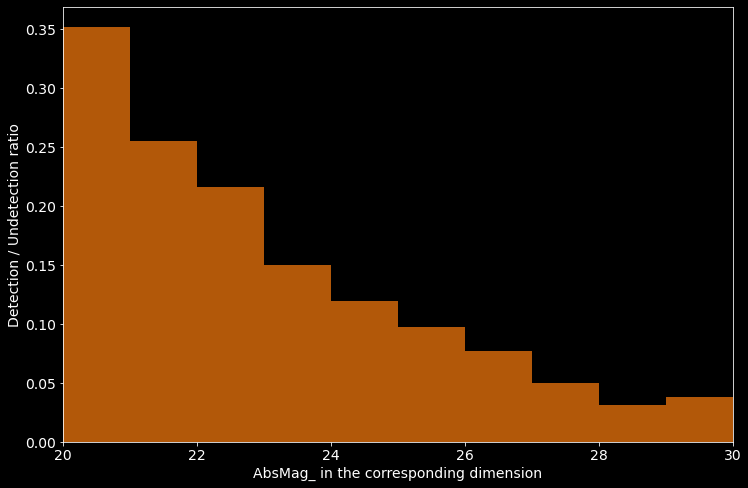

In [7]:
# Here we take a look at the bias of certain elements. We compute the ratio between the
# detected "bins" and the undected ones to see, if orbital elements, or magnitude are biased with
# our simulation setting(s)

# If you want to play around: please go ahead! The default parameters are:
#elem = "AbsMag_"
#bins_range = np.arange(20, 30 + 1, 1)
elem = "AbsMag_"
bins_range = np.arange(20, 30 + 1, 1)
step_size = (bins_range[1]-bins_range[0])

# Use numpy to compute the detection ratio
hist_detec, _ = np.histogram(detected_neo_df[elem], bins=bins_range)
hist_undetec, bin_edges = np.histogram(undetected_neo_df[elem], bins=bins_range)

hist_ratio = hist_detec / hist_undetec
hist_ratio = np.nan_to_num(hist_ratio)

fig, ax = plt.subplots(figsize=(12, 8))

plt.bar(bin_edges[:-1] + step_size / 2, hist_ratio, width=step_size, color="tab:orange", alpha=0.7)
plt.xlim(bins_range[0], bins_range[-1])
plt.xlabel(f"{elem} in the corresponding dimension")
plt.ylabel("Detection / Undetection ratio")
plt.show()

In [8]:
# We can do the same thing also for the NEO classes!
detec_classes_df = detected_neo_df.groupby(by="NEOClass").count().reset_index()[["NEOClass", "Name"]]
detec_classes_df.rename(columns={"Name": "detec_count"}, inplace=True)

undetec_classes_df = undetected_neo_df.groupby(by="NEOClass").count().reset_index()[["NEOClass", "Name"]]
undetec_classes_df.rename(columns={"Name": "undetec_count"}, inplace=True)

merged_classes_df = pd.merge(detec_classes_df, undetec_classes_df, on="NEOClass")
merged_classes_df.loc[:, "detec_ratio"] = merged_classes_df["detec_count"] / merged_classes_df["undetec_count"]

merged_classes_df

,NEOClass,detec_count,undetec_count,detec_ratio
0,Amor,2301,8136,0.282817
1,Apollo,2566,13716,0.187081
2,Aten,290,1975,0.146835
3,Other,10,27,0.370370


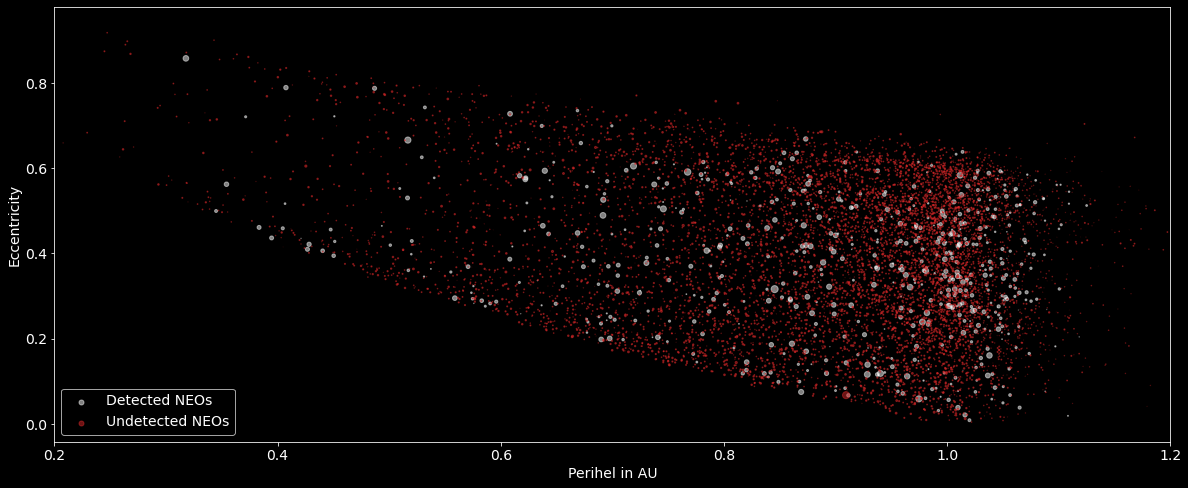

In [9]:
# Hmmm let's take a look at the distribution of the orbital elements

# And we only consider the smaller NEOs (H >= 25 mag)
absmag_limit = 25

# We display the detected and undetected NEOs
temp_detected_neo_df = detected_neo_df.loc[detected_neo_df["AbsMag_"] >= absmag_limit].copy()
temp_undetected_neo_df = undetected_neo_df.loc[undetected_neo_df["AbsMag_"] >= absmag_limit].copy()

# Additionally, our scatter plot will display the size of the NEOs by scaling the scatter points 
temp_detec_l = (temp_detected_neo_df["AbsMag_"] - temp_detected_neo_df["AbsMag_"].min())
temp_detec_size = temp_detec_l * 1.0 / (temp_detec_l.max())

temp_undetec_l = (temp_undetected_neo_df["AbsMag_"] - temp_undetected_neo_df["AbsMag_"].min())
temp_undetec_size = temp_undetec_l * 1.0 / (temp_undetec_l.max())

# And not we plot the results
fig, ax = plt.subplots(figsize=(20, 8))

ax.scatter(temp_detected_neo_df["Perihel_AU"],
           temp_detected_neo_df["Ecc_"],
           s=temp_detec_size * 50,
           color="white",
           alpha=0.5,
           label="Detected NEOs")
ax.scatter(temp_undetected_neo_df["Perihel_AU"],
           temp_undetected_neo_df["Ecc_"],
           s=temp_undetec_size * 50,
           color="tab:red",
           alpha=0.5,
           label="Undetected NEOs")

# Layout and formatting
plt.xlabel("Perihel in AU")
plt.ylabel("Eccentricity")
plt.legend(fancybox=True, loc="lower left")
plt.xlim(0.2, 1.2)

plt.show()

There are indeed a lot of ways to analyse and understand our detection bias. However, this bias is based on the known NEOs ... that could be ... biased too! So in the next step we need to take a simulation model into account.

Additionally, to get a more sophisticated view you can also use Kernel-Density Estimators (KDEs) as have been shown in previous tutorials. You can compute the bias effects in a more quantitative way and / or analyse bias effects for different settings and observation regions (e.g., taking the entire sky into consideration!).

Enjoy!